# Module 3 Project

## Team Monjon

## Contributors : John Naujoks, Mando Iwanaga

----

**Import necessary packages**

In [31]:
# General setup
import pandas as pd
import numpy as np
import re
import itertools

# Preprocessing and scoring
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn_pandas import DataFrameMapper, gen_features

# Modeling tools
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Scoring
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, average_precision_score
from sklearn.metrics import log_loss, roc_auc_score, classification_report
from sklearn.decomposition import PCA


# Visualization
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image  
from sklearn import tree
import pydotplus
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# EDA and Data Cleaning with scrape of 2015-2019 Data
***

**We obtained our dataset through a combination of using boardgamegeek API Python package<br> and scraping  the boardgamegeek website for missing and additional data.**

In [4]:
# Complete dataset is saved in data folder as bgg_complete_1419.csv
bgg = pd.read_csv('data/bgg_complete_1419.csv', 
                   index_col=0,
                   converters={"mechanic": literal_eval, "category": literal_eval} )

In [5]:
bgg.head()

,rank,id,name,age,avg_time,min_players,max_players,mechanic,category,weight,year,geek,avg,num_rev
0,NaN,246783,Wildlands: The Unquiet Dead,14,60,2,4,[],"[Expansion for Base-game, Miniatures]",2.0,2018,5.653,7.44,108.0
1,12558.0,205776,Gentleman's Deal,12,60,5,9,"[Partnerships, Voting]","[Bluffing, Negotiation, Party Game]",1.0,2016,5.514,6.21,47.0
2,13663.0,188129,Heroes and Tricks,8,25,2,6,"[Hand Management, Trick-taking]","[Deduction, Fantasy]",0.0,2017,5.504,5.67,83.0
3,13323.0,206083,Ragers: Champions of the Arena,14,20,2,2,"[Rock-Paper-Scissors, Simultaneous Action Sele...","[Card Game, Fantasy, Fighting]",1.0,2016,5.507,5.98,36.0
4,6390.0,201006,Bumúntú,8,30,2,5,[Action / Movement Programming],"[Animals, Educational]",2.0,2019,5.603,7.15,95.0


In [6]:
# Drop rows with no rank, as they are expansions to games, and not individual games
to_drop = bgg[bgg['rank'].isna()]
bgg.drop(to_drop.index, axis=0, inplace=True)
len(bgg)

3142

In [7]:
# Filling in median value for rows with 0 weight given
bgg.loc[bgg["weight"] == 0] = bgg['weight'].median()

In [8]:
# Double checking that it pulled only those for the correct year
len(bgg[bgg['year'] > 2015]), len(bgg)

(2215, 3142)

In [9]:
# Dropping rows with dates prior to 2015 (bad API pull)
to_drop = bgg[bgg['year'] < 2015]
bgg.drop(to_drop.index, axis=0, inplace=True)

In [10]:
len(bgg)

2986

In [11]:
bgg.describe()

,rank,id,age,avg_time,min_players,max_players,weight,year,geek,avg,num_rev
count,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000
mean,5627.139652,199141.554588,10.568989,125.158741,1.877763,5.687207,2.185205,2016.504689,5.844739,6.967579,844.825184
std,3892.970305,34978.264744,3.419438,2210.236276,0.693686,20.202906,0.777614,1.194408,0.459034,0.757621,2586.059547
min,1.000000,16271.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2015.000000,4.779000,2.440000,30.000000
25%,2452.500000,176533.500000,8.000000,30.000000,1.000000,4.000000,1.600000,2015.000000,5.565000,6.510000,92.000000
50%,5066.500000,197185.000000,12.000000,50.000000,2.000000,4.000000,2.062500,2016.000000,5.653000,6.960000,190.000000
75%,7925.500000,225122.250000,13.000000,90.000000,2.000000,5.000000,2.708300,2017.000000,5.940000,7.430000,539.500000
max,17135.000000,272409.000000,21.000000,120000.000000,8.000000,999.000000,5.000000,2019.000000,8.610000,9.600000,51149.000000


In [12]:
len(bgg[bgg['num_rev'] < 50])

255

In [13]:
# Removing rows with less than 50 reviews
to_drop = bgg[bgg['num_rev'] < 50]
bgg.drop(to_drop.index, axis=0, inplace=True)

In [14]:
bgg.reset_index(inplace=True)
bgg.drop('index', axis=1, inplace=True)
bgg.head()

,rank,id,name,age,avg_time,min_players,max_players,mechanic,category,weight,year,geek,avg,num_rev
0,6390.0,201006.0,Bumúntú,8.0,30.0,2.0,5.0,[Action / Movement Programming],"[Animals, Educational]",2.0000,2019.0,5.603,7.15,95.0
1,3426.0,256839.0,VektoRace,12.0,120.0,2.0,4.0,"[Action / Movement Programming, Simulation]","[Racing, Sports]",2.3333,2018.0,5.785,8.32,196.0
2,6801.0,258104.0,Tribes: Dawn of Humanity,10.0,45.0,2.0,4.0,"[Grid Movement, Tile Placement]","[Ancient, Civilization, Exploration, Prehistor...",2.4000,2018.0,5.590,6.80,99.0
3,5451.0,241796.0,Nut So Fast,8.0,20.0,3.0,6.0,[Pattern Recognition],"[Action / Dexterity, Party Game]",1.0000,2018.0,5.636,7.03,157.0
4,9524.0,233206.0,Werebeasts,8.0,15.0,3.0,10.0,[Set Collection],"[Deduction, Party Game]",1.5000,2018.0,5.543,6.30,94.0


**Our dataset is clean and ready for the modeling process**

---

### Prep for Modeling

In [15]:
bgg['geek'].describe()

count    2731.000000
mean        5.873798
std         0.469515
min         4.779000
25%         5.582000
50%         5.676000
75%         5.989000
max         8.610000
Name: geek, dtype: float64

Here we created a feature called 'top_score' using the geek score. The top 25% will be 1 and the rest will be 0. This feature will be our target for testing.

In [16]:
bgg['top_score'] = bgg['geek'].apply(lambda x: 1 if x > 5.989000 else 0)

In [17]:
bgg.columns

Index(['rank', 'id', 'name', 'age', 'avg_time', 'min_players', 'max_players',
       'mechanic', 'category', 'weight', 'year', 'geek', 'avg', 'num_rev',
       'top_score'],
      dtype='object')

In [18]:
# Define which predictors to drop
to_drop = ['rank', 'id', 'name', 'weight', 'year', 'geek', 'weight', 'avg', 'num_rev']

In [19]:
bgg.drop(to_drop, axis=1, inplace=True)

In [20]:
num_features = gen_features(
         columns=[['age'], ['avg_time'], ['min_players'], ['max_players']],
         classes=[StandardScaler])

cat_features = gen_features(
         columns=['category', 'mechanic'],
         classes=[MultiLabelBinarizer])

combo = num_features + cat_features + [('top_score', None)]

map = DataFrameMapper(combo,df_out=True)

bgg_map_df = map.fit_transform(bgg)

In [25]:
# Define our X and y 
X = bgg_map_df.drop('top_score', axis=1).copy()
y = bgg_map_df['top_score']

In [26]:
# Train-test split and setting a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=66)

*** 

## Modeling

**We will try several classification models for comparisons**

---

## Logistic Regression

In [58]:
logreg = LogisticRegression(solver='liblinear', penalty="l1") #Starter code

logreg.fit(X_train, y_train)

y_score = logreg.predict_proba(X_test)

**Evaluate Logistic Regression**

Log loss: 0.5102066360788797

ROC AUC Score: 0.7079329712667688


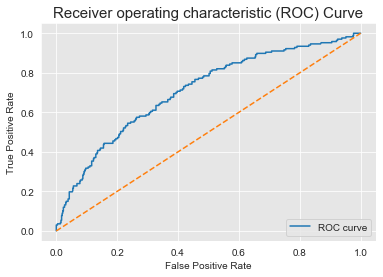

In [60]:
print(f"Log loss: {log_loss(y_test, y_score)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_score[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
#Plot
plt.plot(fpr, tpr, label='ROC curve')
# this is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
plt.show;

In [74]:
# Checking the Cross Validation Score
cross_val_logreg = cross_val_score(logreg, X, y, cv=10)
print(cross_val_logreg)
print(f"Average of Cross val scores: {sum(cross_val_logreg/len(cross_val_logreg))}")

[0.7810219  0.77655678 0.76556777 0.74358974 0.75824176 0.79120879
 0.73260073 0.65934066 0.73992674 0.72161172]
Average of Cross val scores: 0.7469666586454907


----

## Decision Tree

In [62]:
# Set random seed for reproducibility
np.random.seed(123)

clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=3, min_samples_leaf=4)

clf.fit(X_train, y_train)

y_pred_t = clf.predict_proba(X_test)

In [63]:
# Print feature importance percentages to explore how it performed.

vals = clf.feature_importances_.tolist()
best = []
for i, val in enumerate(vals):
    if round(val * 100, 2) > 1:
        print(X.columns[i] + ": " + str(round(val * 100, 2)) + "%")
        best.append(val)

age: 9.82%
avg_time: 29.49%
min_players: 9.12%
category_Card Game: 4.78%
category_City Building: 2.6%
category_Deduction: 1.78%
category_Horror: 2.39%
category_Science Fiction: 1.89%
category_Word Game: 4.15%
mechanic_Campaign / Battle Card Driven: 2.83%
mechanic_Card Drafting: 11.81%
mechanic_Grid Movement: 3.01%
mechanic_Hand Management: 5.69%
mechanic_Hex-and-Counter: 5.91%
mechanic_Storytelling: 4.72%


**Evaluate Decision Tree**

Log loss: 0.6484818260161522

ROC AUC Score: 0.7028675207724087


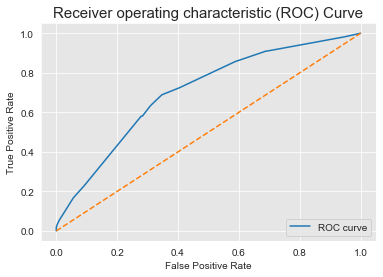

In [64]:
# Seaborn's beautiful styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print(f"Log loss: {log_loss(y_test, y_pred_t)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_t[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_t[:,1])
# Plot
plt.plot(fpr, tpr, label='ROC curve')

# This is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
plt.show;

**Visualization of Decision Tree**

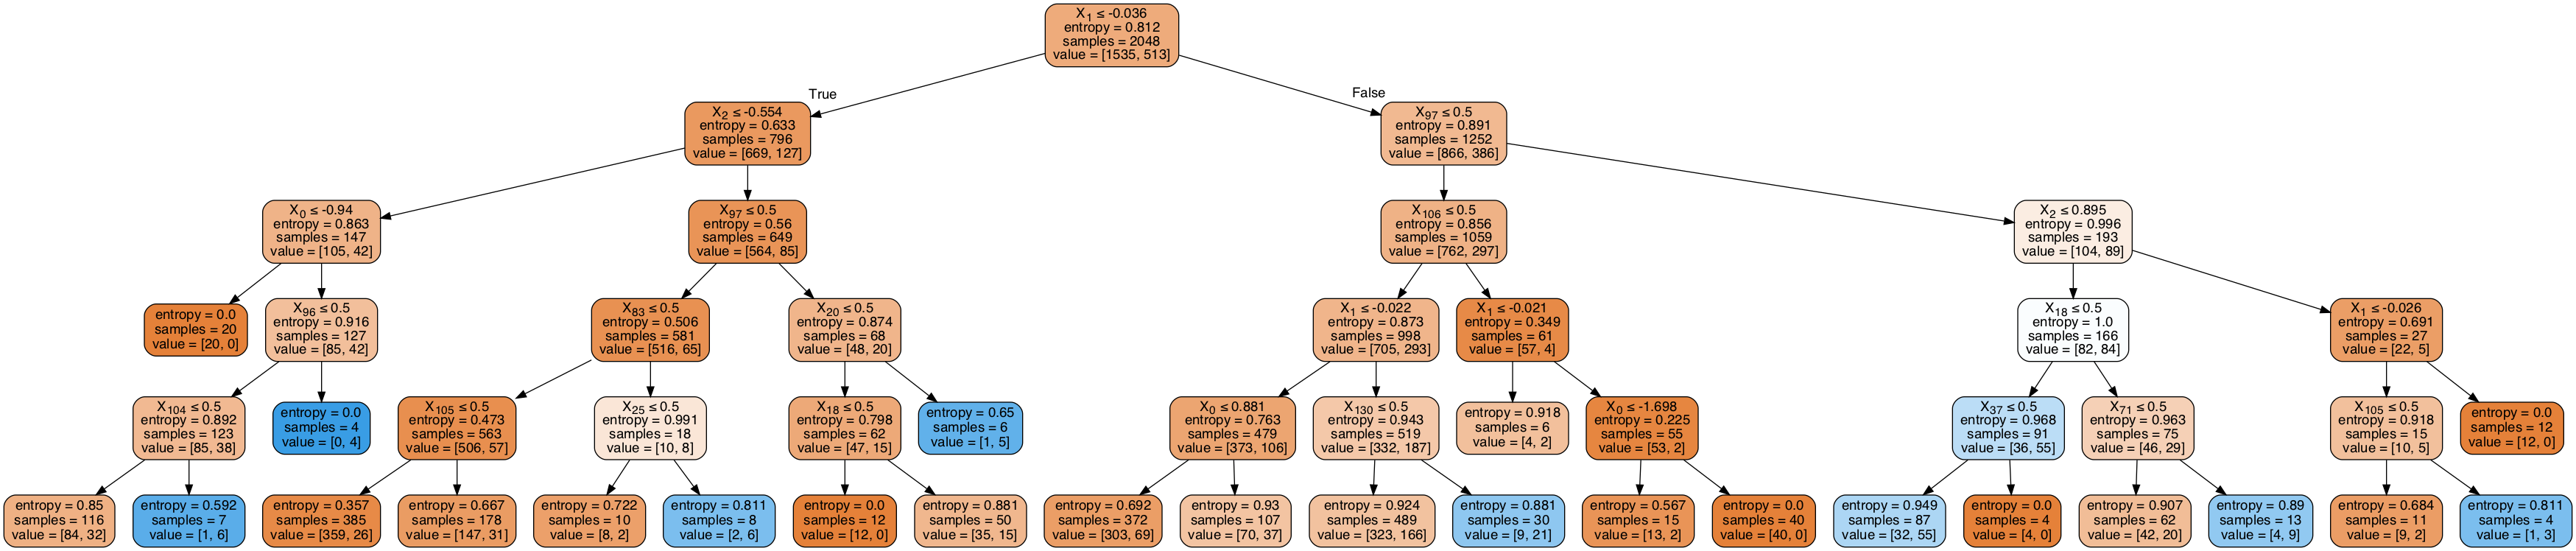

In [65]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [75]:
# Checking the Cross Validation Score
cross_val_clf = cross_val_score(clf, X, y, cv=10)
print(cross_val_clf)
print(f"Average of Cross val scores: {sum(cross_val_clf/len(cross_val_clf))}")

[0.75547445 0.75457875 0.73260073 0.77655678 0.74725275 0.74725275
 0.75457875 0.73992674 0.75824176 0.73992674]
Average of Cross val scores: 0.7506390203470494


---

## Random Forest Classifier

In [67]:
np.random.seed(123)

forest = RandomForestClassifier(n_estimators=28, max_depth=None, min_samples_leaf=2, min_samples_split=4)

forest.fit(X_train, y_train)

y_pred_forest = forest.predict_proba(X_test)
y_pred_f = forest.predict(X_test)

In [68]:
# Print feature importance percentages

vals = forest.feature_importances_.tolist()
best = []
for i, val in enumerate(vals):
    if round(val * 100, 2) > 1:
        print(X.columns[i] + ": " + str(round(val * 100, 2)) + "%")
        best.append(val)

age: 7.49%
avg_time: 9.5%
min_players: 4.64%
max_players: 5.06%
category_Card Game: 1.74%
category_City Building: 1.02%
category_Dice: 1.18%
category_Economic: 1.51%
category_Exploration: 1.07%
category_Fantasy: 1.37%
category_Fighting: 1.36%
category_Medieval: 1.21%
category_Real-time: 1.3%
category_Science Fiction: 1.1%
category_Wargame: 1.02%
mechanic_Action Point Allowance System: 1.25%
mechanic_Area Control / Area Influence: 1.48%
mechanic_Area Movement: 1.01%
mechanic_Card Drafting: 3.73%
mechanic_Cooperative Play: 1.48%
mechanic_Deck / Pool Building: 1.95%
mechanic_Dice Rolling: 1.8%
mechanic_Hand Management: 1.91%
mechanic_Point to Point Movement: 1.07%
mechanic_Press Your Luck: 1.18%
mechanic_Route/Network Building: 1.18%
mechanic_Set Collection: 1.93%
mechanic_Storytelling: 1.06%
mechanic_Tile Placement: 1.4%
mechanic_Variable Player Powers: 2.61%
mechanic_Worker Placement: 1.33%


**Evaluate Random Forest**

Log loss: 0.48443176288806306

ROC AUC Score: 0.7504931996472172


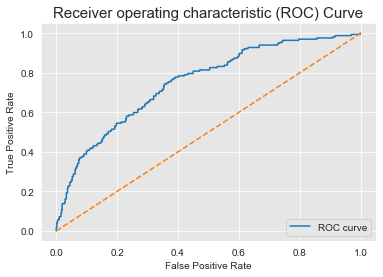

In [69]:
# Seaborn's beautiful styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print(f"Log loss: {log_loss(y_test, y_pred_forest)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_forest[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_forest[:,1])

# Plot of ROC Curve
plt.plot(fpr, tpr, label='ROC curve')

# This is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
plt.show;

In [76]:
# Checking the Cross Validation Score
cross_val_forest = cross_val_score(forest, X, y, cv=10)
print(cross_val_forest)
print(f"Average of Cross val scores: {sum(cross_val_forest/len(cross_val_forest))}")

[0.78467153 0.76923077 0.77655678 0.77289377 0.78388278 0.75824176
 0.73992674 0.72893773 0.73626374 0.75824176]
Average of Cross val scores: 0.7608847357022538


---

## Gradient Boosting Classifier

In [36]:
np.random.seed(123)

boost = GradientBoostingClassifier(learning_rate=.03, max_depth=4, n_estimators=150)

boost.fit(X_train, y_train)

boost_pred = boost.predict_proba(X_test)
boost_conf_pred = boost.predict(X_test)

In [37]:
#Print feature importance percentages

vals = boost.feature_importances_.tolist()
best = []
for i, val in enumerate(vals):
    if round(val * 100, 2) > 1:
        print(X.columns[i] + ": " + str(round(val * 100, 2)) + "%")
        best.append(val)

age: 8.52%
avg_time: 10.24%
min_players: 7.6%
max_players: 5.34%
category_Card Game: 1.47%
category_City Building: 1.22%
category_Deduction: 1.82%
category_Economic: 2.76%
category_Fantasy: 1.04%
category_Medieval: 1.48%
category_Number: 1.2%
category_Real-time: 2.52%
category_Spies/Secret Agents: 1.2%
category_Word Game: 2.38%
mechanic_Card Drafting: 6.75%
mechanic_Cooperative Play: 1.68%
mechanic_Deck / Pool Building: 1.46%
mechanic_Hex-and-Counter: 2.5%
mechanic_Hidden Traitor: 1.5%
mechanic_Paper-and-Pencil: 1.65%
mechanic_Point to Point Movement: 1.01%
mechanic_Route/Network Building: 1.56%
mechanic_Set Collection: 1.16%
mechanic_Storytelling: 1.49%
mechanic_Variable Player Powers: 3.4%
mechanic_Worker Placement: 1.22%


**Evaluate Gradient Boosting**

Log loss: 0.49343252606310173

ROC AUC Score: 0.7237327670240914


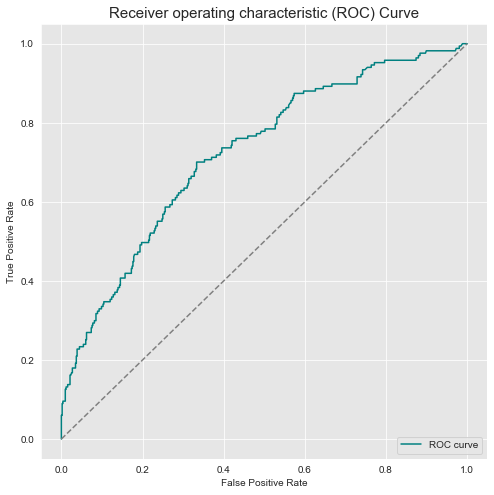

In [38]:
#Seaborn's beautiful styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(8,8))

print(f"Log loss: {log_loss(y_test, boost_pred)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, boost_pred[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, boost_pred[:,1])

#Plot
plt.plot(fpr, tpr, label='ROC curve', color='teal') 

# This is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--', color='grey');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
plt.show;
plt.savefig('../rock.png')

In [72]:
# Checking the Cross Validation Score
print(cross_val_score(boost, X, y, cv=10))

[0.78467153 0.75824176 0.77289377 0.76923077 0.76556777 0.76556777
 0.73992674 0.70695971 0.74358974 0.75824176]


---

### Final thoughts
Based on our results, it appears we achieve very similar results with all our models.  The XG Boost model appears to have done the best, though due to it's computational cost, the Gradient Descent Classifier would probably be our best option. The further checking through Cross Validation gives us confidence that this would be a good model.

---

## GridSearchCV

**Run GridSearch on models to find the best parameters**

**Decision Tree**

In [140]:
param_grid_clf = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 4, 5],
    "min_samples_split": [3, 4, 5],
    "min_samples_leaf": [2, 3, 4, 5]
}

In [141]:
gs_clf = GridSearchCV(clf, param_grid_clf, cv=3)

In [142]:
gs_clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 4, 5], 'min_samples_split': [3, 4, 5], 'min_samples_leaf': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [143]:
gs_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 3}

**Random Forest**

In [147]:
param_grid_forest = {
    "n_estimators": [25, 28, 30, 32],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 3],
    "min_samples_split": [4, 5, 6],
    "min_samples_leaf": [1, 2]
}

In [148]:
gs_forest = GridSearchCV(forest, param_grid_forest, cv=3)

In [149]:
gs_forest.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [25, 28, 30, 32], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 3], 'min_samples_split': [4, 5, 6], 'min_samples_leaf': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [150]:
gs_forest.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 28}